# Building an image embedding server with Gluon
In this notebook, we use a pre-trained model to extract image embeddings.
* Image embeddings are dense, high-semantic, low-dimension vector representation of images learnt by neural networks. They can directly by learnt by a model, or obtained as a byproduct of a downstream task. In this demo, we use a pre-trained classifier from the gluon model zoo to obtain those embeddings
* We use the SageMaker Training platform to copy the model from the model zoo to S3. There is no actual training happening in our `.fit()` call, just a copy from the zoo to S3. The Training abstraction allows us to choose a model with a simple string parameter
* We then use the SageMaker MXNet Serving feature to deploy the embedding model to a real-time managed endpoint
* We query the endpoint and visualize embeddings in a 2D scatter plot using PCA

**This sample is provided for demonstration purposes, make sure to conduct appropriate testing if derivating this code for your own use-cases!**

In [ ]:
import datetime
import json
import os
import subprocess as sb

from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import image, nd
from mxnet.gluon.model_zoo import vision as models
import numpy as np

In [ ]:
%%javascript

//disable autoscroll
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
# some settings for visualisations
%matplotlib inline
plt.style.use('seaborn-pastel')  # set style
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['font.size'] = 15

In [ ]:
# find couple open pics
pics = [
    'https://cdn.pixabay.com/photo/2016/02/16/03/42/lasso-1202578_960_720.jpg',
    'https://cdn.pixabay.com/photo/2015/09/14/20/52/cowboy-940083_1280.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/d/d3/Cowboy.1887.ws.jpg',
    'https://cdn.pixabay.com/photo/2015/05/08/05/33/cowboy-757575_960_720.jpg',
    'https://cdn.pixabay.com/photo/2017/12/03/19/08/wedding-2995641_1280.jpg',
    'https://www.maxpixel.net/static/photo/2x/Bride-And-Groom-Wedding-Ceremony-2729673.jpg',
    'https://cdn12.picryl.com/photo/2016/12/31/wedding-the-groom-bride-nature-landscapes-2c6338-1024.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/a/a4/%22_04_-_ITALIAN_Hypercar_GT_1_-_sport_car_racing_airscoop_intake.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Corbellati_Missile_Genf_2018.jpg/1024px-Corbellati_Missile_Genf_2018.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/7/77/JAGUAR_C-X75_HYBRID_SUPERCAR_%289098871512%29.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/1/1c/Girafeskoure.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/African_Leopard_Chitwa_South_Africa_Luca_Galuzzi_2004.JPG/1024px-African_Leopard_Chitwa_South_Africa_Luca_Galuzzi_2004.JPG',
    'https://www.maxpixel.net/static/photo/2x/Animal-Portrait-Fuchs-Animal-World-Wild-Animal-3532084.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Papio_papio_and_juvenile_Port_Lympne_Wild_Animal_Park.jpg/1600px-Papio_papio_and_juvenile_Port_Lympne_Wild_Animal_Park.jpg',
    'https://cdn.pixabay.com/photo/2018/07/10/22/09/raccoon-3529806_1280.jpg',
    'https://www.nps.gov/katm/learn/nature/images/bear-cubs-intro-pic.jpg?maxwidth=1200&maxheight=1200&autorotate=false',
    'https://upload.wikimedia.org/wikipedia/commons/5/52/Koenigsegg_Agera_R.jpg',
    'https://cdn.pixabay.com/photo/2017/11/09/01/49/ferrari-458-spider-2932191_1280.jpg'
]

In [ ]:
# download pics
sb.call(['mkdir', 'pics'])

path = '/home/ec2-user/SageMaker/pics/'

for p in pics:
    sb.call(['wget', p, '-P', path])

In [ ]:
# reading couple images with mxnet
for p in os.listdir(path)[:3]:
    
    picture = mx.image.imread(os.path.join(path, p))
    plt.imshow(picture.asnumpy())
    plt.show()

## Getting embeddings from a pre-trained classifier, locally
We take models from the gluon model zoo https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html

In [ ]:
modelname = 'resnet152_v2'  # Other interesting options: resnet34_v2, mobilenetv2_0.5

net = models.get_model(name=modelname, pretrained=True)
emb = net.features  # get embeddings, not final probas

In [ ]:
def transform(data):
    """resize, crop, normalize"""
    data = mx.image.resize_short(data, 256)  # resize
    data, _ = mx.image.center_crop(data, (224,224))  # crop
    data = data.transpose((2,0,1)).expand_dims(axis=0)  # channels-first and batch size 1
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std   # ImageNet-normalize


def embeddings(embmodel, pic):
    """get the image embeddings, returns an NDArray"""
    return embmodel(transform(pic)).squeeze()  # flatten if nested dimensions

In [ ]:
# test locally
embeddings(emb, mx.image.imread(path + 'Girafeskoure.jpg'))[:10]  # 10 first coefficients

## Write the embedding model in the SageMaker MXNet specification
https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/mxnet/README.rst#deploying-mxnet-models

The SageMaker MXNet model server breaks request handling into three steps. Each step involves invoking a python function, with information about the request and the return-value from the previous function in the chain:

* input processing, with `input_fn(request_body, request_content_type, model)`
* prediction, with `predict_fn(input_object, model)`
* output processing, with `output_fn(prediction, content_type)`


We don't write an output_fn, because `predict_fn` outputs an NDArray that can be handled to CSV or JSON by the default output_fn

### Create a "Script Mode" training and serving script to copy model from zoo and serve requests
To parametrize the choice of model, we use a "train" phase which just consists of downloading a model from the model zoo and saving it to S3. 

In [ ]:
%%writefile embedding_server.py

import argparse
import logging
import os

import mxnet as mx
from mxnet import nd, gluon
from mxnet.gluon.model_zoo import vision as models




# Inference utilities * * * * * * * * * * * * * * * * * * * *

def transform(data):
    """resize, crop, normalize"""
    data = mx.image.resize_short(data, 256)
    data, _ = mx.image.center_crop(data, (224,224))
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std


def embeddings(embmodel, pic):
    """get the image embeddings, returns an NDArray"""
    return embmodel(transform(pic)).squeeze()  # flatten if nested dimensions


def model_fn(model_dir):
    """
    Load the gluon model. Called once when hosting service starts.
    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a Gluon network)
    
    lil hack: we pass gluon model name as artifact name so that at serving
    we know which model to use
    """
    filename = os.listdir(model_dir)[0]
    print('file found in model_dir: ' + filename)
    modelname = filename[:filename.find('.params')]
    net = models.get_model(name=modelname, pretrained=False, ctx=mx.cpu())
    net.load_parameters(os.path.join(model_dir, filename))
    logging.info('loaded parameters into model ' + filename)

    return net


def input_fn(request_body, request_content_type):
    """prepares the input"""
    output = mx.image.imdecode(request_body)
    logging.info('input_fn returns NDArray of shape ' + str(output.shape))
    return output


def predict_fn(input_object, model):
    """function used for prediction"""
    emb = model.features
    return embeddings(emb, input_object)




# Training (no training, just copy from zoo to S3) * * * * * * * * * * * * * * * *

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # extract parameters
    # avoid error when running locally with non-declared os.environ['SM_MODEL_DIR']
    try:
        len(os.environ['SM_MODEL_DIR'])
    except:
        os.environ['SM_MODEL_DIR'] = 'local'
    
    parser.add_argument('--gluon-model-name', type=str, default='resnet18_v2')
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])

    args, _ = parser.parse_known_args()


    # extract model
    net = models.get_model(name=args.gluon_model_name, pretrained=True, ctx=mx.cpu())

    # save model
    net.save_parameters(os.path.join(args.model_dir, args.gluon_model_name + '.params'))

### Test the script locally
The powerful Script Mode design allows us to use the same code locally or in SageMaker

In [ ]:
! mkdir testdir

In [ ]:
# running the script just downloads a model from the model zoo and writes it to the dir of our choice
! python embedding_server.py --gluon-model-name resnet34_v2 --model-dir '/home/ec2-user/SageMaker/testdir/'

### Instantiate a SageMaker Estimator, train and deploy
Training is not actually training a model, it is just copying a model from gluon model zoo to S3

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel
from sagemaker.mxnet.estimator import MXNet

sess = sagemaker.Session()

embedding_model = MXNet(
    entry_point='embedding_server.py',
    py_version='py3',
    framework_version='1.3',
    train_instance_count=1,
    train_instance_type='ml.m5.xlarge',
    output_path='s3://' + sess.default_bucket(),  # don't hesitate to change target bucket here
    role=get_execution_role(),
    hyperparameters={'gluon-model-name': modelname})

In [ ]:
%%time
embedding_model.fit(logs=False)  # fit without input. The training just copies from gluon zoo to S3

In [ ]:
endpoint_key = ((modelname + '-embedding').replace('_', '-').replace('.', '') + '-' 
                + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))

embedding_model.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
    endpoint_name=endpoint_key)

## Submit requests to the embedding server

### Produce embeddings of images

In [ ]:
# instantiate a predictor
predictor = sagemaker.predictor.RealTimePredictor(
    endpoint=endpoint_key,
    content_type='image/jpeg')

In [ ]:
def get_emb(pic, predictor):
    """elementary function to send a picture to a predictor"""
    
    with open(pic, 'rb') as image:
        f = image.read()

    return json.loads(predictor.predict(f))

In [ ]:
# test with the same image as the local inference on top of notebook

get_emb(path + 'Girafeskoure.jpg', predictor)[:10]  # first 10 coefficents of the embedding

In [ ]:
# loop through images to create embeddings of all images

picnames = os.listdir(path)

image_embs = np.expand_dims(get_emb(os.path.join(path, picnames[0]), predictor), axis=0)

for p in picnames[1:]:
    print('getting embedding for ' + p)
    image_embs = np.concatenate(
        (image_embs, np.expand_dims(get_emb(os.path.join(path, p), predictor), axis=0)))

### Visualize the semantic similarity in the embedding space

In [ ]:
# PCA of embedding
from sklearn.decomposition import PCA
import pandas as pd

X_pca = PCA(2).fit_transform(image_embs)
emb = pd.DataFrame(X_pca, columns=['pca1', 'pca2'])
emb['pic'] = picnames
emb['url'] = [os.path.join(path, p) for p in picnames]

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def scatter(data, x, y, logx=False, logy=False, s=200, alpha=0.5, color='r',
    pic_url=False, pic_zoom=0.1):
    """
    plots a scatter plot with image thumbnails - NOT THOROUGHLY TESTED!
    
    Parameters
    ----------
    data : pandas dataframe, required
        the dataframe containing the input data to plot and optionally some metadata

    x, y : strings, required
        features to plot in x-axis and y-axis, identified by their column name in 'data'

    s : int, optional (defaults to 200)
        the size of the round plot marker

    alpha : float between 0 and 1, optional (defaults to 0.5)
        the opacity of the plot markers

    color : string (optional, default is red)
        marker color or list of colors
    
    pic_url : string (optional)
        url of the picture to display at each marker. This is the column name of the column
        storing each picture path in the input dataframe

    pic_zoom : float between 0 and 1, optional (defaults to 0.5)
        the size ratio of images

    label : string (optional)
        column in input dataframe to use as label
    """
    
    features = [x, y]

    if pic_url != False:
        features.append(pic_url)

    temp = data[features].dropna().reset_index()
    
    ax = temp.plot(kind='scatter', x=x, y=y, logx=logx, logy=logy,
        s=s, color=color, alpha=alpha)

    if pic_url != False:
        for i in range(len(temp)):
            imagebox = OffsetImage(plt.imread(temp[pic_url][i]), zoom=pic_zoom)
            ab = AnnotationBbox(imagebox, [temp[x][i], temp[y][i]],
                xybox=(30., -30.),
                xycoords='data',
                boxcoords='offset points',
                bboxprops =dict(edgecolor='r'))                                 
            ax.add_artist(ab)  

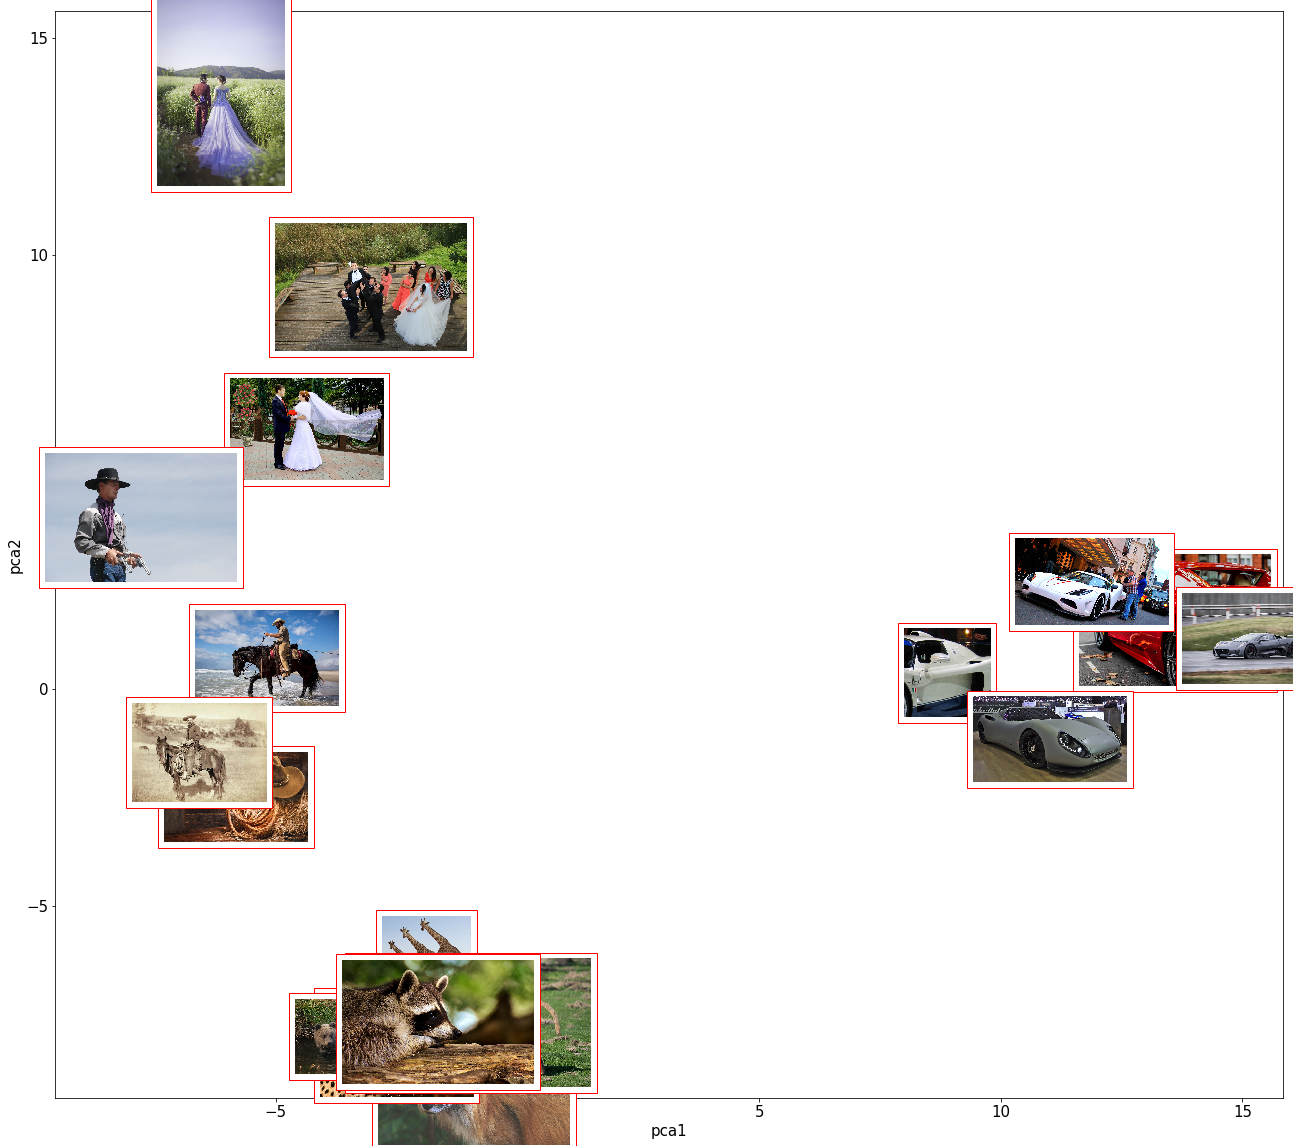

In [50]:
# some settings for visualisations
%matplotlib inline
plt.style.use('seaborn-pastel')  # set style
plt.rcParams['figure.figsize'] = [22,20]
plt.rcParams['font.size'] = 15

scatter(data=emb, x='pca1', y='pca2', pic_url='url', pic_zoom=0.15)

## Don't forget to delete the endpoint after the demo!